## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Generating synthetic data and a Heat map

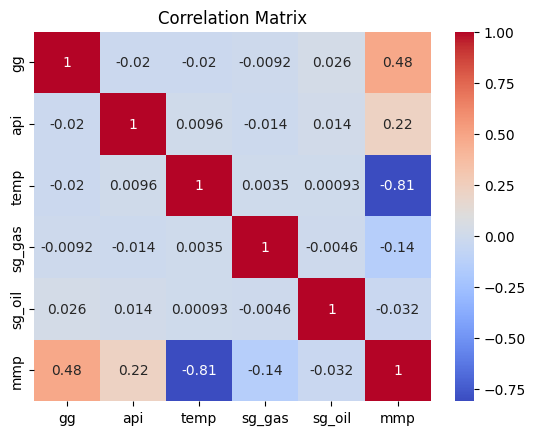

In [2]:
def standing(gg, api, temp, sg_gas, sg_oil):
    # convert inputs to SI units
    temp_si = (temp - 32) * 5/9 + 273.15
    api_si = (141.5 / api) + 131.5
    # calculate critical properties of the gas and oil
    tc_gas = 168 + 325*sg_gas - 12.5*sg_gas**2
    pc_gas = 677 + 15*tc_gas - 37.5*tc_gas**2
    tc_oil = 304.6 - 203.1*api_si + 55.5*api_si**2
    pc_oil = 677 + 15*tc_oil - 37.5*tc_oil**2
    # calculate reduced temperature and pressure
    tr = temp_si / tc_gas
    pr = 0.27 * gg / (sg_gas * tr)
    # calculate correction factor for non-hydrocarbons
    z1 = 0.3265 - 1.07/tr + 1.5/tr**2
    z2 = 0.27 - 0.07*z1
    # calculate coefficients for the Standing equation
    a = 0.3265 / tr**0.9578 * np.exp(0.0887*(1-tr**1.2)*pr**0.45*(z1-1))
    b = 0.0271 / tr**1.242 * np.exp(0.0179*(1-tr**1.2)*pr**0.45*(z2-1))
    # calculate MMP
    mmp = 435.8 * a / (b + 0.7*pr) * tc_oil / temp_si * np.exp(0.00074*api_si)
    # convert output to oil field units
    mmp_of = 0.145*pr*gg*api / (sg_oil**0.5 * temp)
    return mmp_of

# Generate synthetic data
gg = np.random.uniform(0.6, 0.8, size=5000) # gas gravity (API)
api = np.random.uniform(30, 40, size=5000) # oil API gravity
temp = np.random.uniform(80, 180, size=5000) # reservoir temperature (F)
sg_gas = np.random.uniform(0.5, 0.7, size=5000) # gas specific gravity
sg_oil = np.random.uniform(0.8, 0.9, size=5000) # oil specific gravity
mmp = standing(gg, api, temp, sg_gas, sg_oil)

# Concatenate inputs and output column-wise
data = np.column_stack((gg, api, temp, sg_gas, sg_oil, mmp))

# Create a pandas dataframe
df = pd.DataFrame(data, columns=['gg', 'api', 'temp', 'sg_gas', 'sg_oil', 'mmp'])

# Calculate and plot the correlation matrix
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

## Train and evaluate our Model

In [3]:
# Concatenate inputs and output column-wise
X = np.column_stack((gg, api, temp, sg_gas, sg_oil))
y = mmp

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.1,
                         kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         normalize_y=True)

Mean squared error: 1.9054702295771108e-06
R2 score: 0.8800700546759953


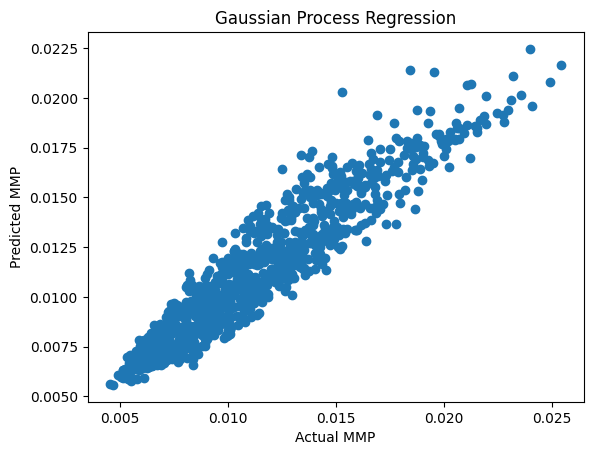

In [4]:
# Predict on the test set
y_pred = gp.predict(X_test)


# Calculate and print metrics
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

# Plot predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual MMP')
plt.ylabel('Predicted MMP')
plt.title('Gaussian Process Regression')
plt.show()

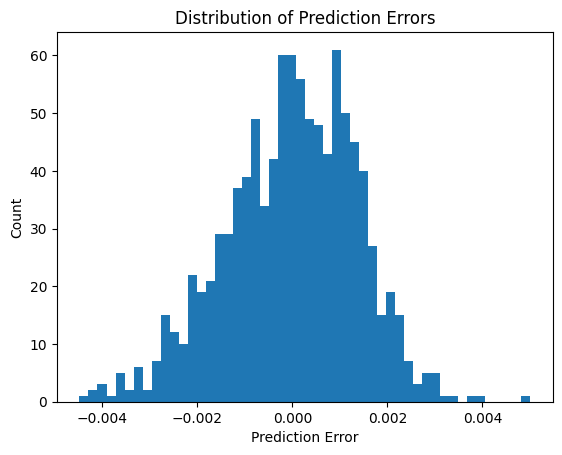

In [5]:
# Plot the distribution of errors
errors = y_pred - y_test
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.show()